# Preprocessing data with ecv and nutritional metrics 

### Objective

The objective of this notebook is to preprocess the data through the following five steps:

1. Handling Missing Data
2. Exploratory Data Analysis (EDA)
3. Data Visualization and PCA
4. Outlier Detection
5. Bias Detection


In [1]:
import pandas as pd
import requests
from pathlib import Path
import json
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np

from pathlib import Path
import sys

project_root = Path.cwd().parent
sys.path.append(str(project_root))

from src.utils import *

In [2]:
DATA_DIR = Path(project_root / "data")
RECIPES_FILE = DATA_DIR / "all_recipes_clean.json"

In [3]:
with open(RECIPES_FILE, "r", encoding="utf-8") as f:
    recipes = json.load(f)

df = pd.DataFrame(recipes)


In [4]:
df_rating = df[df['rating'] != 0]
len(df_rating)

1693

In [4]:
df_vege = df[df["is_vege"] != 0]
df_non_vege = df[df["is_vege"] == 0]
df_non_vege = df_non_vege[df_non_vege["rating"] != 0]
df_vege = df_vege[df_vege["rating"] != 0]

In [5]:
df_vege.describe()

,rating,total_ecv,total_kcal,total_protein,total_fat,is_vege
count,719.000000,719.000000,719.000000,719.000000,719.000000,719.0
mean,4.193463,0.503403,483.571343,20.744347,29.403670,1.0
std,0.811631,0.691062,454.006741,18.119606,35.260098,0.0
min,1.000000,0.013862,11.999999,0.125000,0.070000,1.0
25%,4.000000,0.199403,178.000000,7.469722,3.916667,1.0
50%,4.400000,0.281702,313.593750,20.584444,22.254545,1.0
75%,4.800000,0.589080,614.366667,27.147394,35.189545,1.0
max,5.000000,7.218667,3037.486441,202.528000,233.177017,1.0


In [6]:
df_non_vege.describe()

,rating,total_ecv,total_kcal,total_protein,total_fat,is_vege
count,974.000000,974.000000,974.000000,974.000000,974.000000,974.0
mean,4.544251,8.139262,2044.819099,137.578431,141.798741,0.0
std,0.502617,11.478987,2291.408450,131.957442,209.003927,0.0
min,1.000000,0.333565,106.750000,5.166667,2.720000,0.0
25%,4.400000,1.504026,580.200000,65.400000,24.805000,0.0
50%,4.700000,3.335652,1158.658974,94.500000,51.173636,0.0
75%,4.800000,9.393191,2271.574192,167.840000,143.470869,0.0
max,5.000000,95.785142,13396.533333,922.948377,1330.613333,0.0


## 1. Handling missing data 

In [7]:
col_missing = pd.DataFrame({
    "contain missing data": df.isna().sum() != 0,
    "missing_frequency": df.isna().mean() * 100
})
display(col_missing)

,contain missing data,missing_frequency
title,False,0.0
url,False,0.0
rating,False,0.0
ingredients,False,0.0
total_ecv,False,0.0
total_kcal,False,0.0
total_protein,False,0.0
total_fat,False,0.0
is_vege,False,0.0


## 2. Exploratory Data Analysis (EDA)

In [8]:
print("Shape (rows, cols):", df.shape)
print("Number of elements:", df.size)
print(df.dtypes)
print(df["ingredients"])

Shape (rows, cols): (2089, 9)
Number of elements: 18801
title             object
url               object
rating           float64
ingredients       object
total_ecv        float64
total_kcal       float64
total_protein    float64
total_fat        float64
is_vege            int64
dtype: object
0       [{'ingredient_name': 'tomates', 'quantity': 20...
1       [{'ingredient_name': 'poireau', 'quantity': 15...
2       [{'ingredient_name': 'carotte', 'quantity': 40...
3       [{'ingredient_name': 'oeuf', 'quantity': 60.0,...
4       [{'ingredient_name': 'beurre', 'quantity': 20....
                              ...                        
2084    [{'ingredient_name': 'carottes', 'quantity': 1...
2085    [{'ingredient_name': 'beurre', 'quantity': 100...
2086    [{'ingredient_name': 'beurre', 'quantity': 40....
2087    [{'ingredient_name': 'tomates', 'quantity': 20...
2088    [{'ingredient_name': 'carotte', 'quantity': 15...
Name: ingredients, Length: 2089, dtype: object


Nombre de recettes par catégorie

is_vege
0    1099
1     990
Name: count, dtype: int64


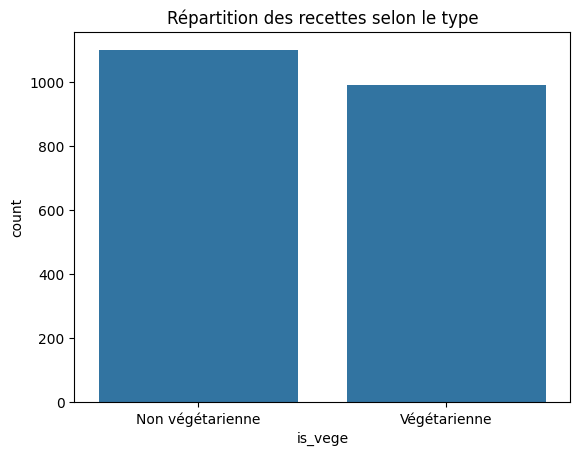

In [9]:
print(df["is_vege"].value_counts())
sns.countplot(x="is_vege", data=df)
plt.xticks([0,1], ["Non végétarienne", "Végétarienne"])
plt.title("Répartition des recettes selon le type")
plt.show()

Unique ingredients

In [10]:
unique_ingredients = get_unique_ingredients(recipes)

len(unique_ingredients)

190

Statistiques descriptives

In [11]:
display(df.describe())

,rating,total_ecv,total_kcal,total_protein,total_fat,is_vege
count,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000,2089.000000
mean,3.562087,4.642496,1312.338509,83.023534,88.529056,0.473911
std,1.827000,9.402856,1843.500741,114.237639,161.124883,0.499438
min,0.000000,0.013862,11.400000,0.125000,0.060000,0.000000
25%,3.300000,0.316533,309.000000,20.746061,15.400000,0.000000
50%,4.400000,1.368129,635.836364,41.333333,30.850000,0.000000
75%,4.800000,4.410986,1429.097778,101.984444,82.304545,1.000000
max,5.000000,95.785142,13396.533333,922.948377,1330.613333,1.000000


Distributions

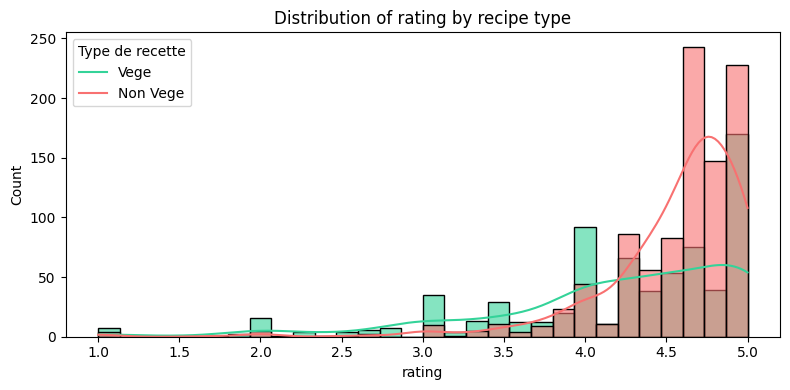

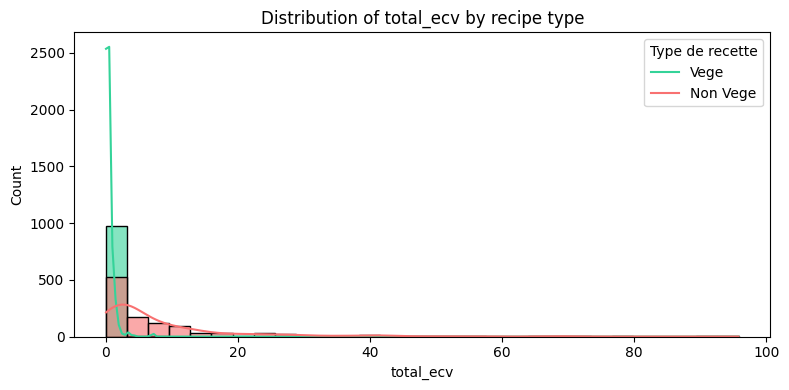

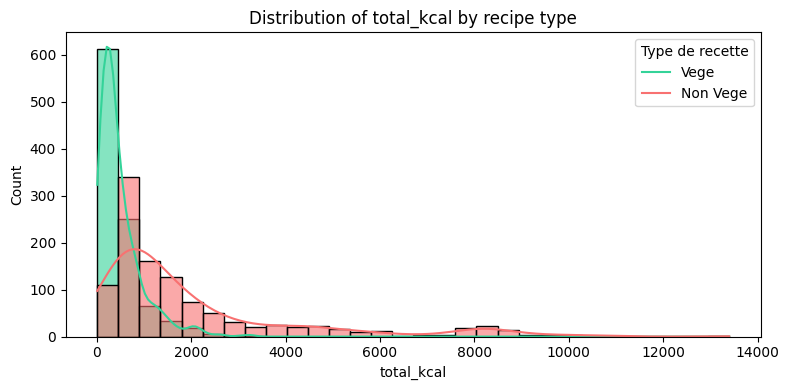

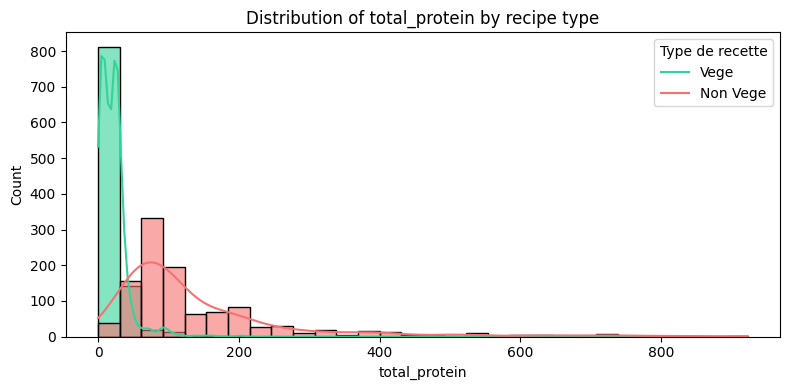

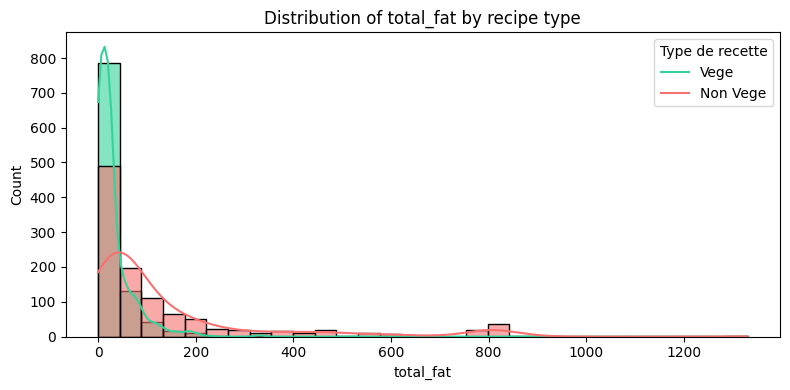

In [12]:
num_features = ["rating", "total_ecv", "total_kcal", "total_protein", "total_fat"]
for feature in num_features:
    df_plot = df[df['rating'] > 0] if feature == 'rating' else df
    plt.figure(figsize=(8,4))
    sns.histplot(
        data=df_plot,
        x=feature,
        hue="is_vege",           # separate by veg/non-veg
        bins=30,
        palette=['#F87171', '#34D399'],  # red=non-veg, green=veg
        alpha=0.6,
        kde=True                  # add density curve
    )
    plt.title(f"Distribution of {feature} by recipe type")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend(title="Type de recette", labels=["Vege", "Non Vege"])
    plt.tight_layout()
    plt.show()

Comparaison de moyennes

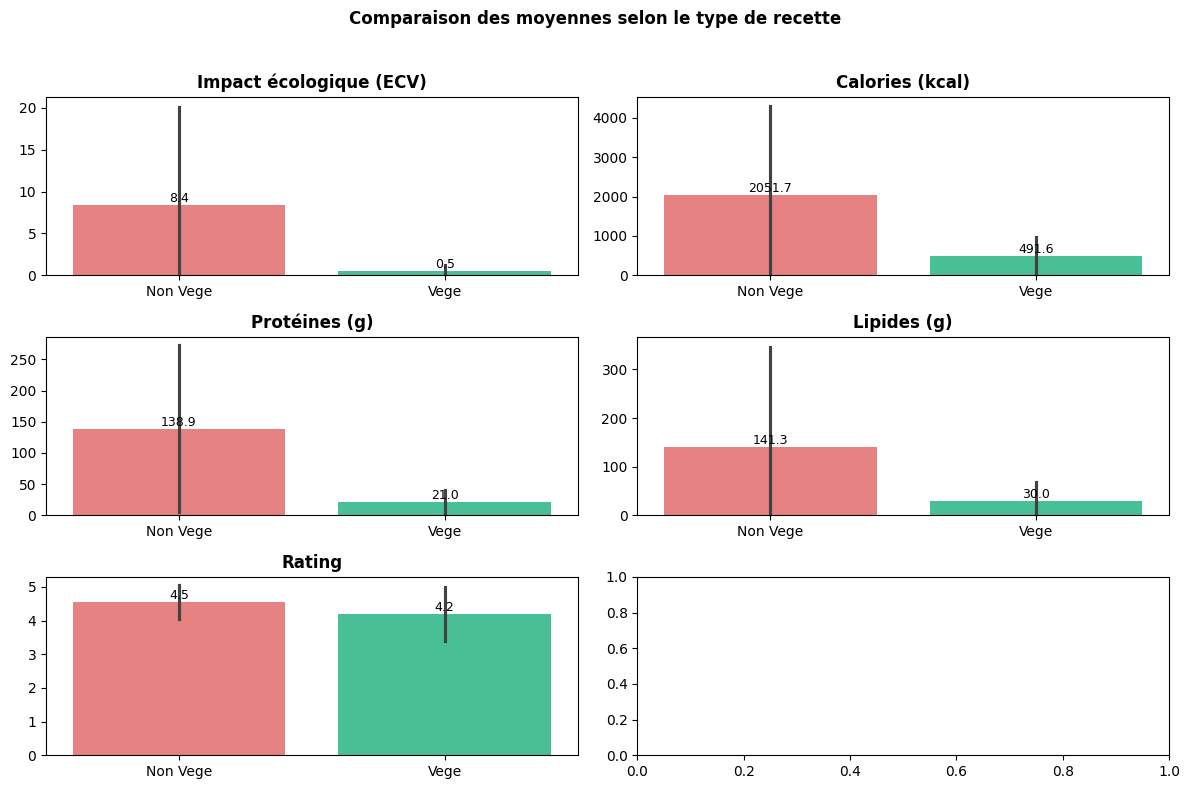

In [13]:
metrics = ['total_ecv', 'total_kcal', 'total_protein', 'total_fat', 'rating']
labels = {
    'total_ecv': "Impact écologique (ECV)",
    'total_kcal': "Calories (kcal)",
    'total_protein': "Protéines (g)",
    'total_fat': "Lipides (g)",
    'rating': "Rating"
}

fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    # assign hue to match palette use (fixes FutureWarning)
    df_plot = df[df['rating'] != 0] if metric == 'rating' else df
    sns.barplot(
        data=df_plot,
        x='is_vege',
        y=metric,
        hue='is_vege',                   # <- required for palette
        errorbar='sd',
        palette=['#F87171', '#34D399'],
        ax=ax,
        legend=False                     # hide redundant legend
    )

    ax.set_title(labels[metric], weight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("")

    # set both ticks and labels (fixes UserWarning)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Non Vege", "Vege"])

    ax.set_ylim(bottom=0)

    # add mean value labels
    for p in ax.patches:
        value = p.get_height()
        if not np.isnan(value):  # avoid NaN text
            ax.annotate(f"{value:.1f}",
                        (p.get_x() + p.get_width() / 2., value),
                        ha='center', va='bottom', fontsize=9)

plt.suptitle("Comparaison des moyennes selon le type de recette", weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Correlations

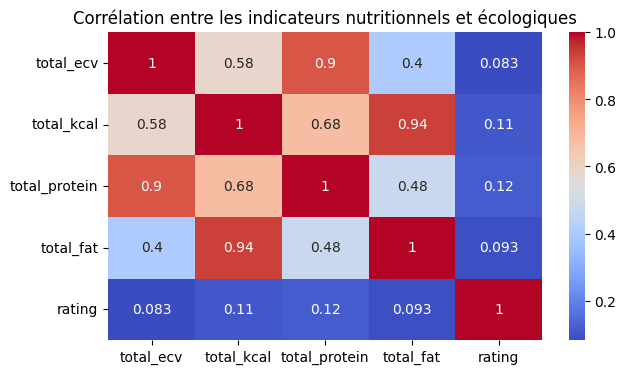

In [14]:
# Toutes recettes
plt.figure(figsize=(7,4))
sns.heatmap(df[['total_ecv', 'total_kcal', 'total_protein', 'total_fat', 'rating']].corr(), annot=True, cmap='coolwarm')
plt.title("Corrélation entre les indicateurs nutritionnels et écologiques")
plt.show()

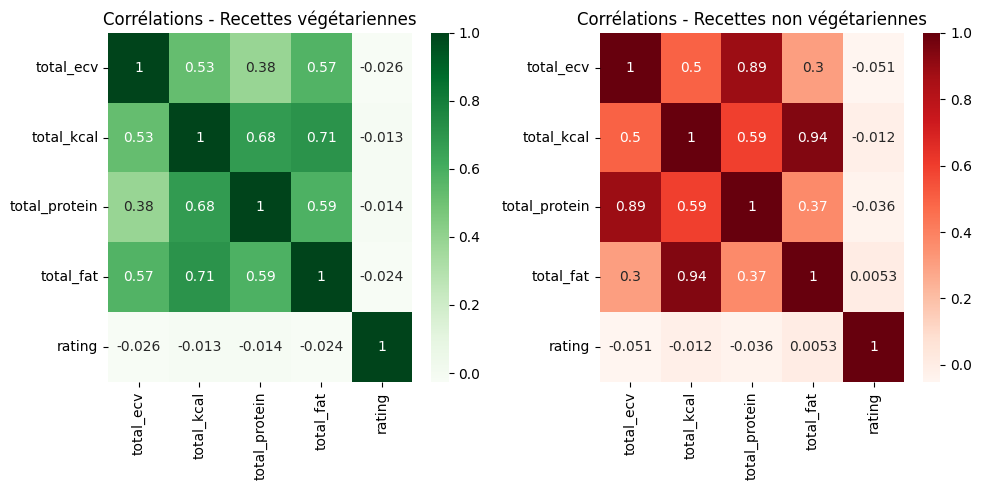

In [15]:
# Par type de recette
corr_vege = df[df['is_vege']==1][['total_ecv','total_kcal','total_protein','total_fat', 'rating']].corr()
corr_nonvege = df[df['is_vege']==0][['total_ecv','total_kcal','total_protein','total_fat', 'rating']].corr()

fig, axes = plt.subplots(1,2, figsize=(10,5))
sns.heatmap(corr_vege, annot=True, cmap="Greens", ax=axes[0])
sns.heatmap(corr_nonvege, annot=True, cmap="Reds", ax=axes[1])
axes[0].set_title("Corrélations - Recettes végétariennes")
axes[1].set_title("Corrélations - Recettes non végétariennes")
plt.tight_layout()
plt.show()

Scatterplots

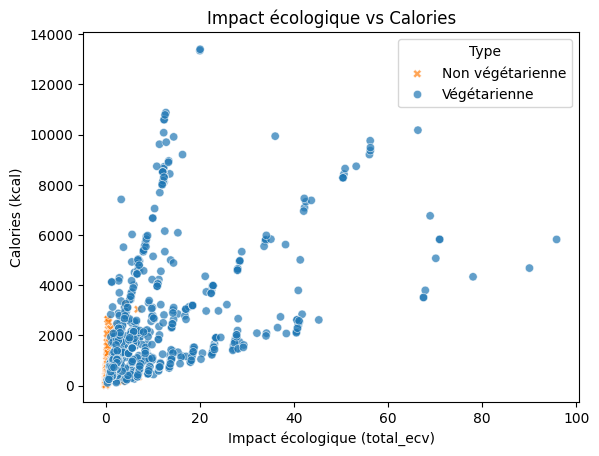

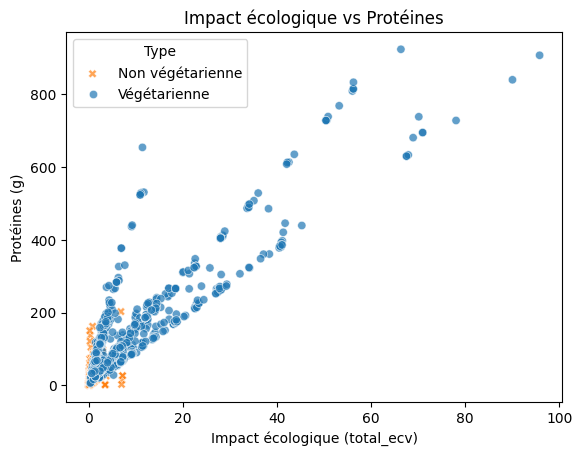

In [16]:
sns.scatterplot(data=df, x='total_ecv', y='total_kcal', hue='is_vege', style='is_vege', alpha=0.7)
plt.title("Impact écologique vs Calories")
plt.xlabel("Impact écologique (total_ecv)")
plt.ylabel("Calories (kcal)")
plt.legend(title="Type", labels=["Non végétarienne", "Végétarienne"])
plt.show()

sns.scatterplot(data=df, x='total_ecv', y='total_protein', hue='is_vege', style='is_vege', alpha=0.7)
plt.title("Impact écologique vs Protéines")
plt.xlabel("Impact écologique (total_ecv)")
plt.ylabel("Protéines (g)")
plt.legend(title="Type", labels=["Non végétarienne", "Végétarienne"])
plt.show()

La normalization ne change rien aux graphes

Recettes les plus et moins écologiques

In [17]:
print("Recettes les plus sobres écologiquement :")
display(df.nsmallest(8, 'total_ecv')[['title', 'total_ecv', 'total_kcal', 'total_protein', 'rating', "is_vege"]])

print("Recettes les plus impactantes écologiquement :")
display(df.nlargest(8, 'total_ecv')[['title', 'total_ecv', 'total_kcal', 'total_protein', 'rating', "is_vege"]])

df["score"] = df["total_protein"] - df["total_ecv"]
top_recipes = df.nlargest(8, "score")[["title","total_ecv", 'total_kcal', "total_protein","rating", "is_vege"]]
print("Recettes les plus optimales (riches en protéines, faibles en impact écologique) :")
display(top_recipes)

Recettes les plus sobres écologiquement :


,title,total_ecv,total_kcal,total_protein,rating,is_vege
140,Fajitas végétariennes aux haricots rouges,0.013862,13.300000,0.315000,3.8,1
374,Chili vegan aux poivrons,0.013862,13.300000,0.315000,0.0,1
386,Soupe façon Chinoise vegan,0.013862,13.300000,0.315000,0.0,1
199,TARTE AU CHOCOLAT ET AMANDES GRILLEES PAR ZAKO...,0.016902,21.362727,1.813909,0.0,1
645,"Sablé breton, crème légère vanille et rhubarbe...",0.016902,21.362727,1.813909,0.0,1
705,Mayonnaise légère à ma façon,0.016902,21.362727,1.813909,3.6,1
851,Mayonnaise légère au curry,0.016902,21.362727,1.813909,0.0,1
985,Millefeuille léger aux fraises et au mascarpone,0.016902,21.362727,1.813909,4.3,1


Recettes les plus impactantes écologiquement :


,title,total_ecv,total_kcal,total_protein,rating,is_vege
1443,"Osso-buco Milanaise, gremolata, spaghettis",95.785142,5821.316667,906.486389,5.0,0
1061,Ris de Veau aux champignons,90.018613,4680.000000,839.200000,4.8,0
1460,RIS de VEAU AUTHENTIQUE et RAPIDE,78.036720,4333.166667,727.415556,4.3,0
1034,Kebab capucin à l'effiloché d'agneau,70.944551,5823.918182,694.217727,0.0,0
1665,Kebab capucin à l'effiloché d'agneau,70.944551,5823.918182,694.217727,0.0,0
1958,Restes de poulet sauce fond de veau,70.124997,5069.565476,737.651984,0.0,0
1051,Rouelle de porc à l'ancienne,68.922851,6762.722222,680.233333,4.7,0
1191,Filet mignon de veau au cidre,67.892278,3793.658974,632.847466,4.8,0


Recettes les plus optimales (riches en protéines, faibles en impact écologique) :


,title,total_ecv,total_kcal,total_protein,rating,is_vege
1719,Boeuf bourguignon express,66.326332,10174.784416,922.948377,4.8,0
1443,"Osso-buco Milanaise, gremolata, spaghettis",95.785142,5821.316667,906.486389,5.0,0
1952,Chili burger (burger épicé),56.243701,9480.680519,832.419221,0.0,0
1081,Filet mignon de porc fondant en cocotte,56.196248,9754.710823,814.093766,4.6,0
1792,Daube provençale à l'ancienne,56.222673,9357.044156,813.913766,4.5,0
1079,Daube provençale,56.025271,9202.494156,808.391266,4.4,0
1061,Ris de Veau aux champignons,90.018613,4680.000000,839.200000,4.8,0
1597,"Rôti de boeuf au four, sauce aux champignons e...",53.217423,8736.051948,767.822078,4.9,0


## 3. Visualization - PCA

In [18]:
#data = df[df['rating'] != 0]
data = df

Scatter matrix of the pairwise features

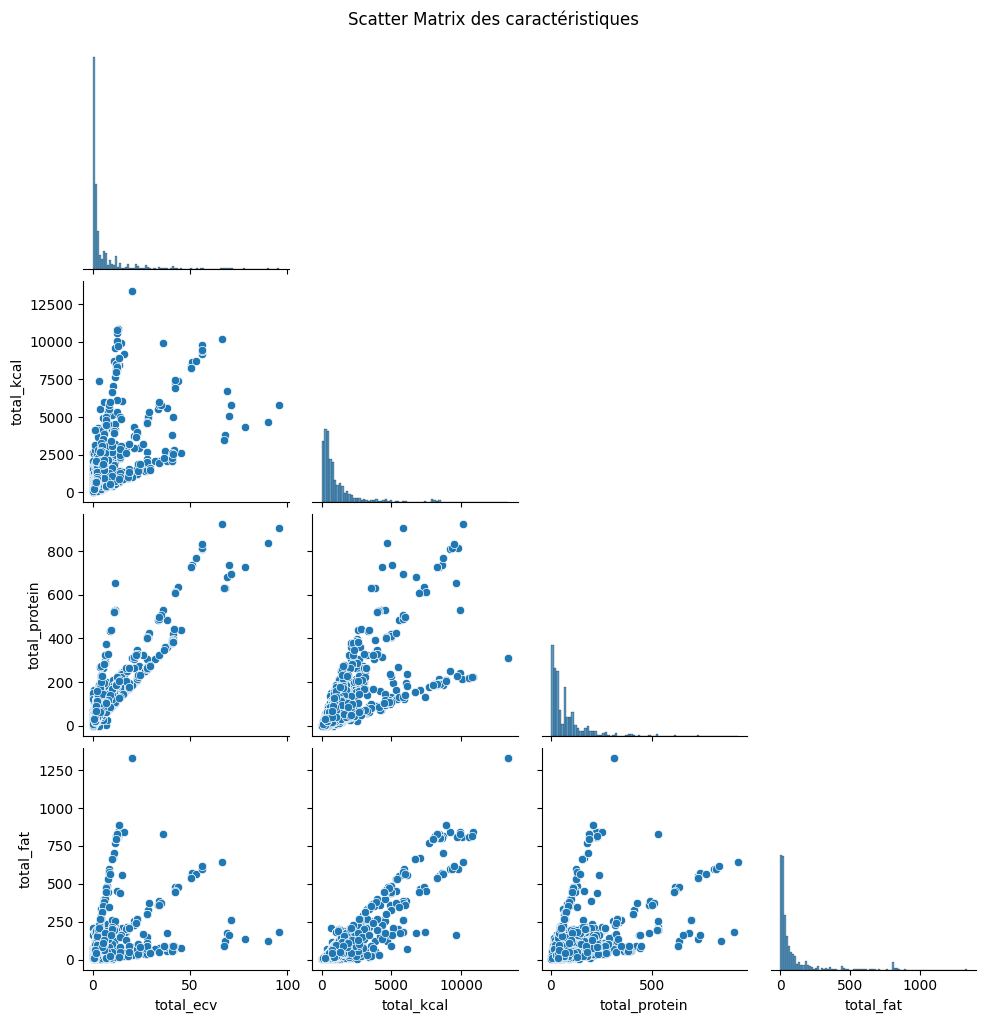

In [19]:
num_features = ["total_ecv", "total_kcal", "total_protein", "total_fat"]
sns.pairplot(data[num_features], corner=True)
plt.suptitle("Scatter Matrix des caractéristiques", y=1.02)
plt.show()

Violin plots

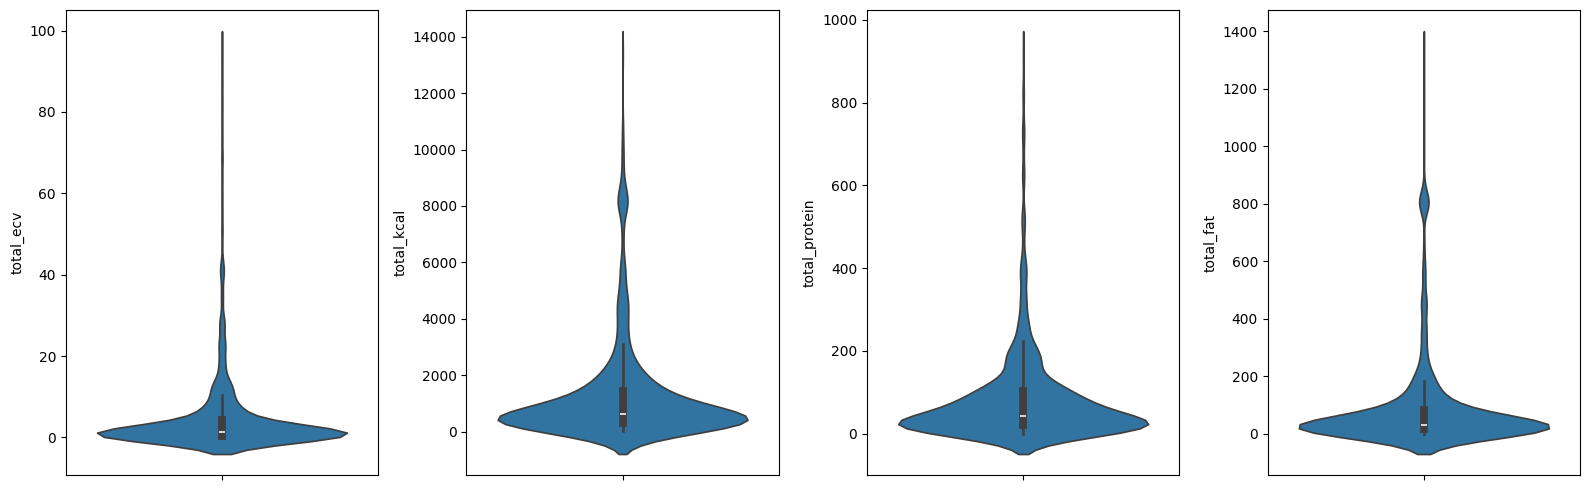

In [20]:
n_features = len(num_features)


fig, axes = plt.subplots(1, n_features, figsize=(4*n_features, 5))  # 1 ligne, n colonnes
for i, col in enumerate(num_features):
    sns.violinplot(y=data[col], ax=axes[i])

plt.tight_layout()
plt.show()

In [21]:
print((data[num_features] <= 0).sum())  # check zeros or negatives


total_ecv        0
total_kcal       0
total_protein    0
total_fat        0
dtype: int64


PCA

In [22]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
data_log = np.log(data[num_features])
data_scaled = scaler.fit_transform(data_log)
data_scaled_df = pd.DataFrame(data_scaled, columns=data_log.columns)

pca = PCA()
pca.fit(data_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Sum of explained variance ratio:", pca.explained_variance_ratio_.sum())

# Contribution of each feature to each component
loadings = pd.DataFrame(pca.components_, columns=num_features, index=[f"PC{i+1}" for i in range(len(num_features))])
display(loadings)

Explained variance ratio: [0.8663349  0.0725022  0.03693396 0.02422895]
Sum of explained variance ratio: 1.0


,total_ecv,total_kcal,total_protein,total_fat
PC1,0.496086,0.510017,0.503551,0.490119
PC2,-0.586312,0.250935,-0.346223,0.688040
PC3,-0.390031,-0.538555,0.712885,0.222777
PC4,-0.507949,0.621991,0.344036,-0.486574


Proportions of variances

In [23]:
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()

summary_table = pd.DataFrame({
    "EV": explained_variance,
    "EVR": explained_variance_ratio,
    "CEVR": cumulative_explained_variance_ratio
}, index=[f'PC{i+1}' for i in range(pca.n_components_)])

print(summary_table)

           EV       EVR      CEVR
PC1  3.466999  0.866335  0.866335
PC2  0.290148  0.072502  0.938837
PC3  0.147807  0.036934  0.975771
PC4  0.096962  0.024229  1.000000


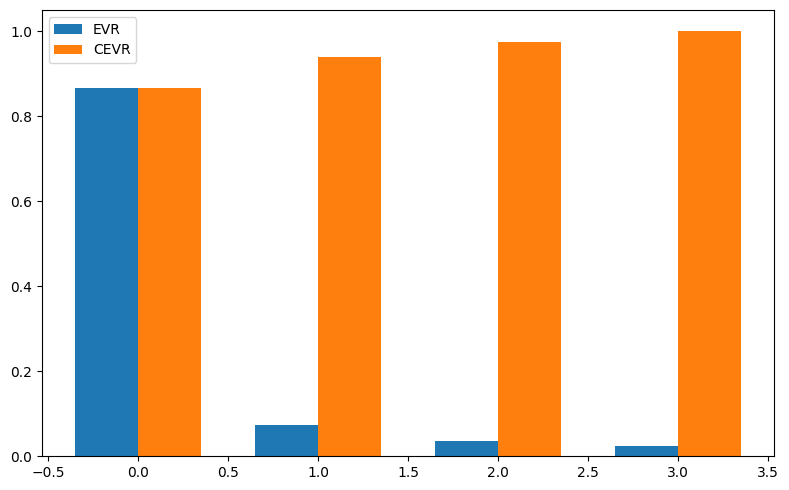

In [24]:
index=[f'PC{i+1}' for i in range(pca.n_components_)]
x = np.arange(len(explained_variance_ratio))
width = 0.35  # width of each bar

plt.figure(figsize=(8,5))

# Plot the two bars side-by-side
plt.bar(x - width/2, explained_variance_ratio, width, label="EVR")
plt.bar(x + width/2, cumulative_explained_variance_ratio, width, label="CEVR")

plt.legend()
plt.tight_layout()
plt.show()

In [25]:
pca_new = PCA(n_components=2) # Keep the first two principal components
pca_new = pca_new.fit(data_scaled)
coord = pca_new.transform(data_scaled)

pca_data = pd.DataFrame(
    coord,
    columns=[f'PC{i+1}' for i in range(2)],
)
pca_data['is_vege'] = data['is_vege'].values

print(pca_data)

           PC1       PC2  is_vege
0    -1.677698 -0.514346        1
1    -1.983275 -0.285118        1
2    -1.955778 -0.468105        1
3    -2.040099  0.436027        1
4    -1.275983  0.522447        1
...        ...       ...      ...
2084  1.144585 -1.241353        0
2085  2.010828 -0.711849        0
2086  1.817008 -0.948113        0
2087  2.644653 -0.284671        0
2088  0.475291 -0.061796        0

[2089 rows x 3 columns]


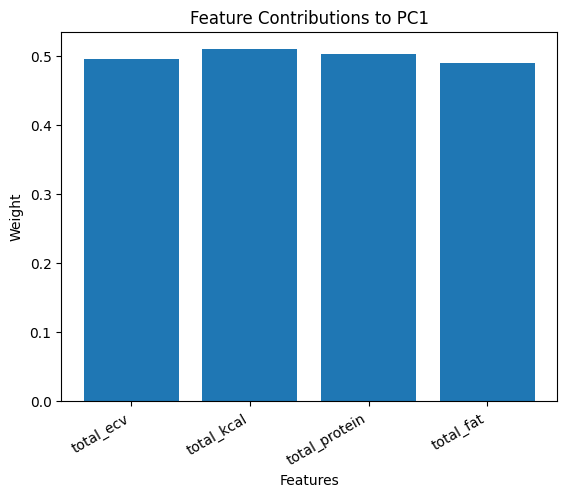

In [26]:
#plt.bar(x=range(6),height=pca.components_[0])
plt.bar(x=data_scaled_df.columns,height=pca.components_[0]);
plt.xlabel("Features")
plt.ylabel("Weight")
plt.xticks(rotation=30, ha='right');
plt.title("Feature Contributions to PC1");

In [27]:
# Keep the number of components explaining ≥ 90% variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1

pca_final = PCA(n_components=n_components)
X_pca = pca_final.fit_transform(data_scaled)

# Create DataFrame for transformed data
X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])
X_pca_df.head()

,PC1,PC2
0,-1.677698,-0.514346
1,-1.983275,-0.285118
2,-1.955778,-0.468105
3,-2.040099,0.436027
4,-1.275983,0.522447


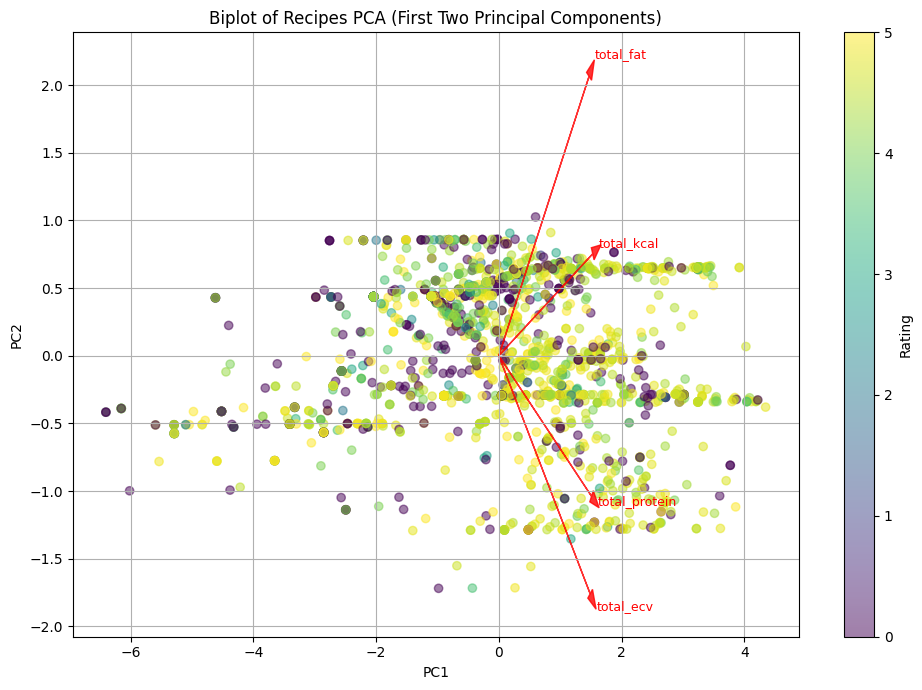

In [28]:
# Loadings (principal component weights)
loadings = pca_final.components_.T  

plt.figure(figsize=(10, 7))

# Plot first two principal components, colored by rating
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, c=data['rating'], cmap='viridis')
plt.colorbar(label='Rating')

# Draw loading vectors for each numeric feature
for i, feature in enumerate(num_features):
    plt.arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3, 
              color='red', alpha=0.8, head_width=0.1)
    plt.text(loadings[i, 0]*3.2, loadings[i, 1]*3.2, feature, color='red', fontsize=9)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of Recipes PCA (First Two Principal Components)')
plt.grid(True)
plt.tight_layout()
plt.show()


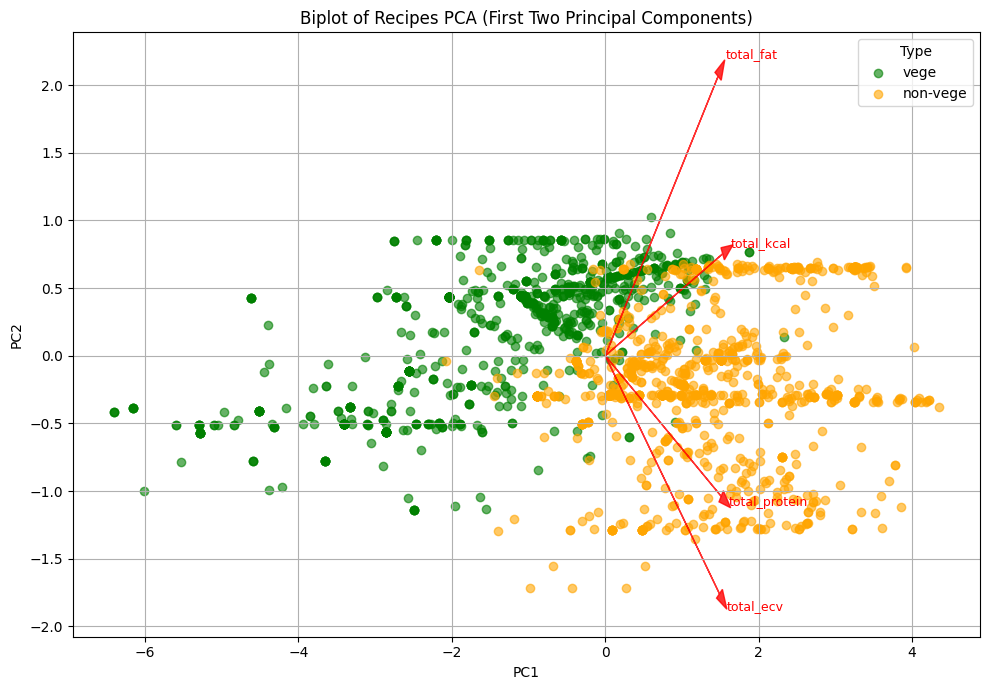

In [29]:
# Loadings (principal component weights)
loadings = pca_final.components_.T  

plt.figure(figsize=(10, 7))

# Define colors for vege vs non-vege
colors = {'vege': 'green', 'non-vege': 'orange'}
vege_labels = data['is_vege'].map({1: 'vege', 0: 'non-vege'})

# Plot first two principal components, colored by vege/non-vege
for label in colors:
    subset = X_pca[vege_labels == label]
    plt.scatter(subset[:, 0], subset[:, 1], 
                alpha=0.6, c=colors[label], label=label)

plt.legend(title='Type')
# Draw loading vectors for each numeric feature
for i, feature in enumerate(num_features):
    plt.arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3, 
              color='red', alpha=0.8, head_width=0.1)
    plt.text(loadings[i, 0]*3.2, loadings[i, 1]*3.2, feature, 
             color='red', fontsize=9)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of Recipes PCA (First Two Principal Components)')
plt.grid(True)
plt.tight_layout()
plt.show()


## 4. Outlier detection

In [30]:
cov = np.cov(X_pca.T)
inv_cov = np.linalg.inv(cov)
mean_vec = np.mean(X_pca, axis=0)

mahalanobis_dist = []
for x in X_pca:
    diff = x - mean_vec
    md = np.sqrt(diff.dot(inv_cov).dot(diff.T))
    mahalanobis_dist.append(md)

data["mahalanobis_dist"] = mahalanobis_dist

# 4. Threshold for outliers (e.g., 99th percentile)
threshold = np.percentile(mahalanobis_dist,99)
data["is_outlier"] = data["mahalanobis_dist"] > threshold

len(data[data["is_outlier"] == True])

16

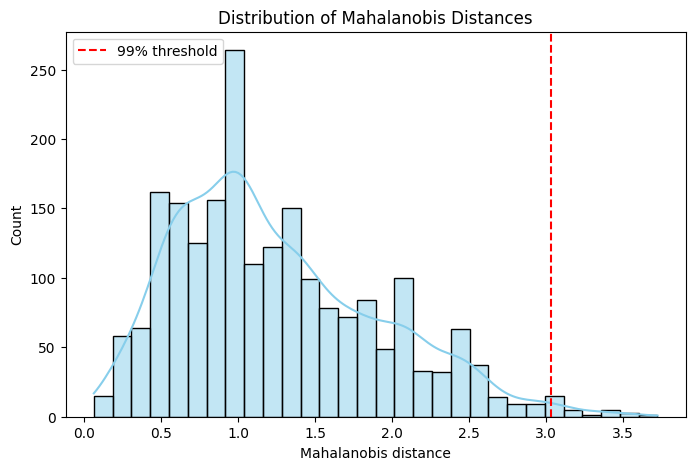

In [31]:
plt.figure(figsize=(8,5))
sns.histplot(data["mahalanobis_dist"], bins=30, kde=True, color="skyblue")
plt.axvline(np.percentile(data["mahalanobis_dist"], 99), color="red", linestyle="--", label="99% threshold")
plt.title("Distribution of Mahalanobis Distances")
plt.xlabel("Mahalanobis distance")
plt.ylabel("Count")
plt.legend()
plt.show()

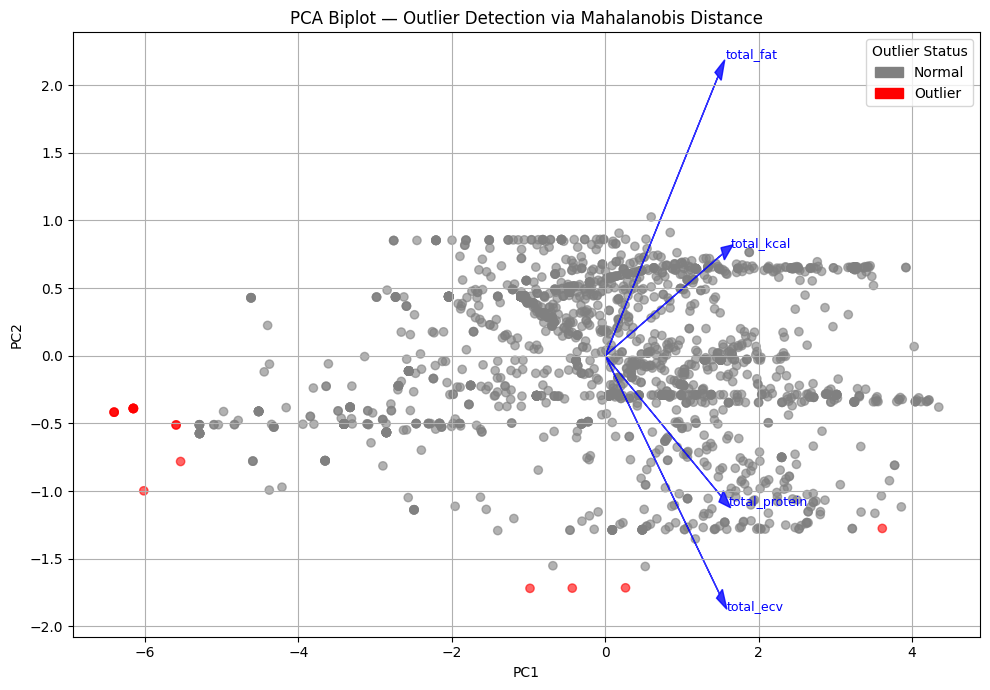

In [32]:
# Loadings (principal component weights)
loadings = pca_final.components_.T  

plt.figure(figsize=(10, 7))

colors = data["is_outlier"].map({False: 'gray', True: 'red'})

plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    alpha=0.6,
    c=colors
)

# Add a legend manually
import matplotlib.patches as mpatches
plt.legend(
    handles=[
        mpatches.Patch(color='gray', label='Normal'),
        mpatches.Patch(color='red', label='Outlier')
    ],
    title='Outlier Status'
)

# Draw loading vectors for each numeric feature
for i, feature in enumerate(num_features):
    plt.arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3, 
              color='blue', alpha=0.8, head_width=0.1)
    plt.text(loadings[i, 0]*3.2, loadings[i, 1]*3.2, feature, color='blue', fontsize=9)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Biplot — Outlier Detection via Mahalanobis Distance')
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
def mad_based_outlier(series, threshold=3.5):
    median = np.median(series)
    mad = np.median(np.abs(series - median))
    if mad == 0:
        return np.zeros(len(series), dtype=bool)
    robust_z = 0.6745 * (series - median) / mad
    return np.abs(robust_z) > threshold


In [34]:
outlier_masks = {}
for col in num_features:
    outlier_masks[col] = mad_based_outlier(df[col])

In [35]:
outlier_rows = np.any(pd.DataFrame(outlier_masks), axis=1)
df_outliers = df[outlier_rows]

In [36]:
print(f"Total outliers detected: {df_outliers.shape[0]}")

Total outliers detected: 492


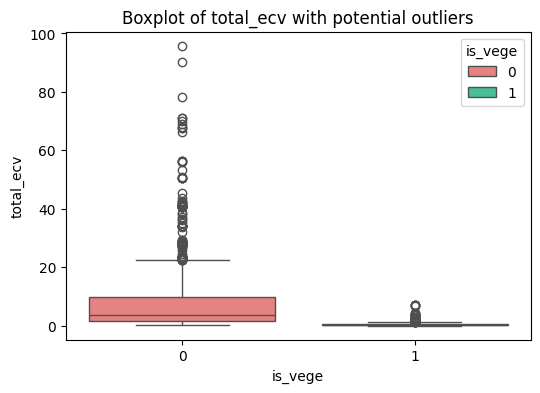

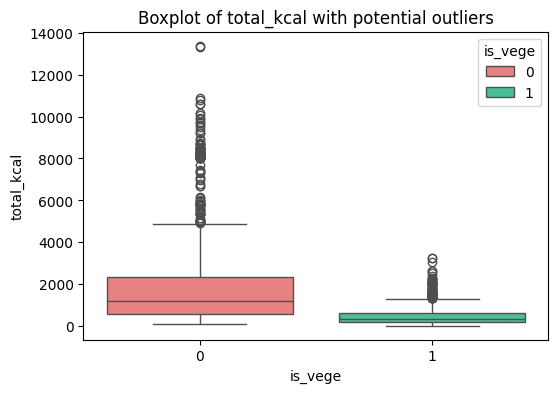

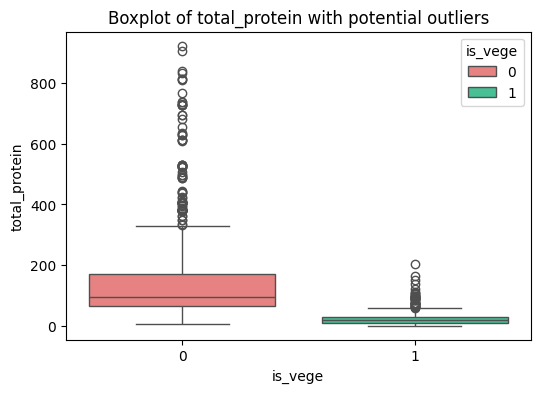

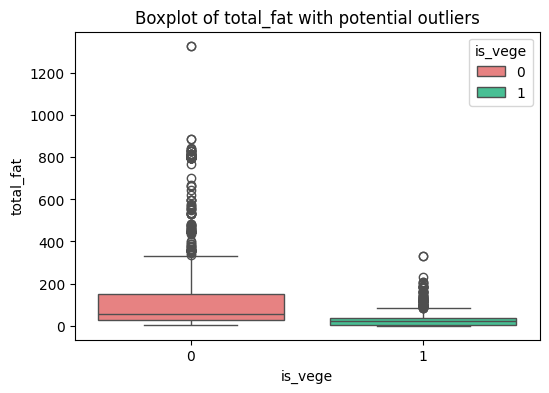

In [37]:
for feature in num_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="is_vege", hue="is_vege", y=feature, palette=['#F87171','#34D399'])
    plt.title(f"Boxplot of {feature} with potential outliers")
    plt.show()

/var/folders/my/27r6mb7d4sg2pyvcl7qgcf680000gn/T/ipykernel_92048/2720689954.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non végé", "Végétarienne"])
/var/folders/my/27r6mb7d4sg2pyvcl7qgcf680000gn/T/ipykernel_92048/2720689954.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non végé", "Végétarienne"])
/var/folders/my/27r6mb7d4sg2pyvcl7qgcf680000gn/T/ipykernel_92048/2720689954.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non végé", "Végétarienne"])
/var/folders/my/27r6mb7d4sg2pyvcl7qgcf680000gn/T/ipykernel_92048/2720689954.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a

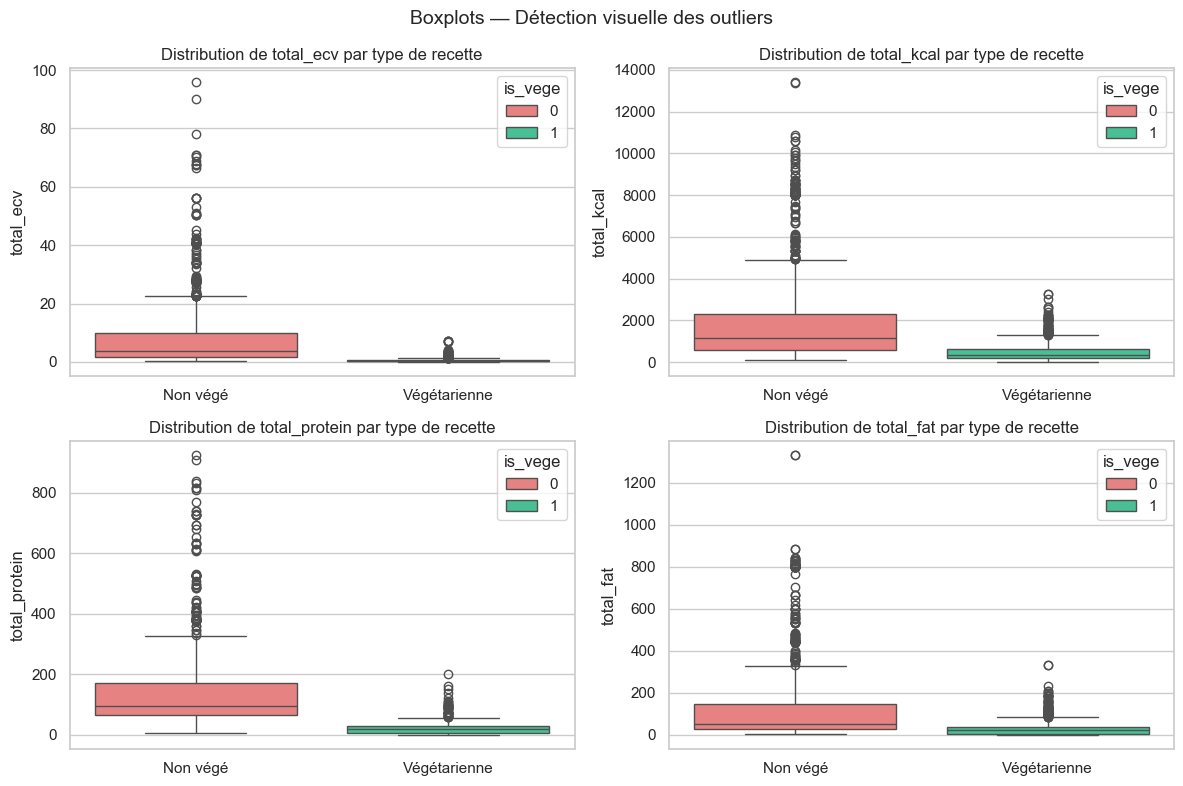

In [38]:
# Version visuelle
numeric_cols = ["total_ecv", "total_kcal", "total_protein", "total_fat"]

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, col in enumerate(numeric_cols):
    ax = axes[i//2, i%2]
    sns.boxplot(data=df, x="is_vege", y=col, hue="is_vege",
                palette=["#F87171", "#34D399"], ax=ax)
    ax.set_title(f"Distribution de {col} par type de recette")
    ax.set_xlabel("")
    ax.set_ylabel(col)
    ax.set_xticklabels(["Non végé", "Végétarienne"])

plt.suptitle("Boxplots — Détection visuelle des outliers", fontsize=14)
plt.tight_layout()
plt.show()

In [39]:
# Version quantitative
outliers = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outliers[col] = n_outliers

outliers_df = pd.DataFrame.from_dict(outliers, orient='index', columns=['Nombre d’outliers'])
display(outliers_df)

,Nombre d’outliers
total_ecv,265
total_kcal,214
total_protein,157
total_fat,233


In [40]:
# Filtre des outliers pour travailler sur df_filtered ? 
df_filtered = df.copy()
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_filtered = df_filtered[(df_filtered[col] >= lower) & (df_filtered[col] <= upper)]

df_filtered.describe()

,rating,total_ecv,total_kcal,total_protein,total_fat,is_vege,score,mahalanobis_dist
count,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000
mean,3.501358,1.550021,660.516834,45.215071,37.848310,0.576151,43.665050,1.099071
std,1.855689,2.008760,533.224149,40.683405,38.478781,0.494313,39.392826,0.613949
min,0.000000,0.013862,11.400000,0.125000,0.060000,0.000000,-4.593306,0.063394
25%,3.000000,0.235565,284.836364,13.554684,12.000000,0.000000,13.134341,0.670733
50%,4.400000,0.791333,495.000000,30.567955,24.000000,1.000000,29.927251,1.006006
75%,4.800000,1.750122,878.169697,65.557500,48.307500,1.000000,64.031871,1.362245
max,5.000000,10.304352,2960.708333,221.880000,179.969778,1.000000,217.194450,3.724636


## 5. Biases

#### Representation bias — group balance

In [41]:
data['is_vege'].value_counts(normalize=True)


is_vege
0    0.526089
1    0.473911
Name: proportion, dtype: float64

#### Rating bias — difference in ratings between groups

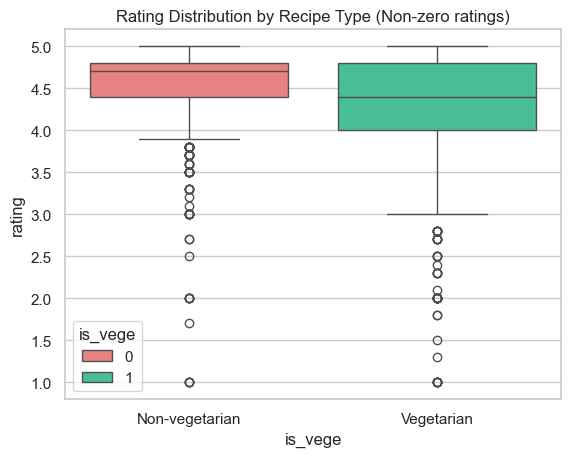

t-test p-value: 1.5175712479017484e-23


In [42]:
# Remove recipes with rating == 0
data_nonzero = data[data["rating"] > 0].copy()

# Boxplot: ratings by recipe type
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=data_nonzero,
    hue="is_vege",
    x="is_vege", y="rating",
    palette=["#F87171", "#34D399"]
)
plt.xticks([0, 1], ["Non-vegetarian", "Vegetarian"])
plt.title("Rating Distribution by Recipe Type (Non-zero ratings)")
plt.show()

# Statistical test (Welch’s t-test)
from scipy.stats import ttest_ind

tstat, pval = ttest_ind(
    data_nonzero.loc[data_nonzero["is_vege"]==0, "rating"],
    data_nonzero.loc[data_nonzero["is_vege"]==1, "rating"],
    equal_var=False
)
print(f"t-test p-value: {pval}")


In [43]:
print(data_nonzero.groupby("is_vege")["rating"].mean())


is_vege
0    4.544251
1    4.193463
Name: rating, dtype: float64


#### Feature bias — are nutritional features systematically different?

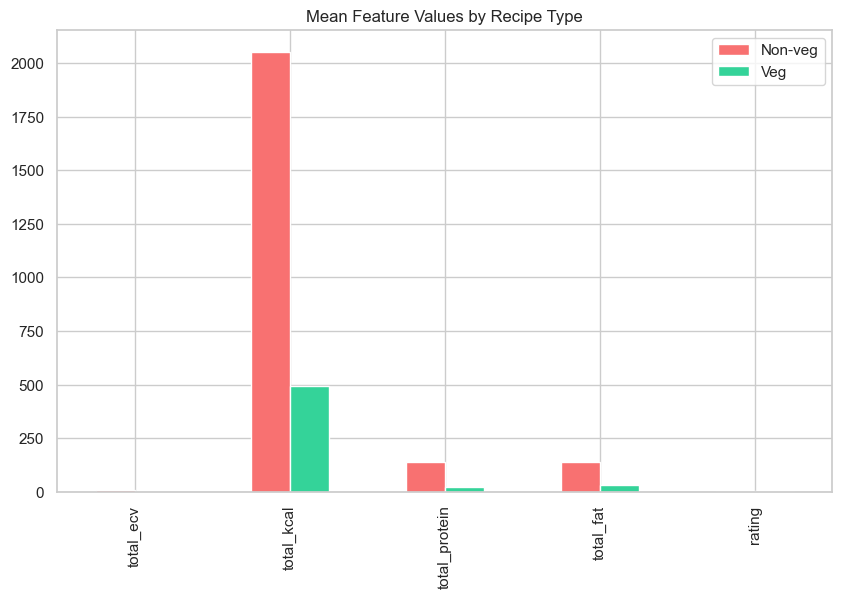

In [44]:
num_features = ["total_ecv", "total_kcal", "total_protein", "total_fat", "rating"]
group_means = data.groupby("is_vege")[num_features].mean().T
group_means.plot(kind="bar", figsize=(10,6), color=["#F87171", "#34D399"])
plt.title("Mean Feature Values by Recipe Type")
plt.legend(["Non-veg", "Veg"])
plt.show()
